### Solution for the 3D cell problem (modified to be as in P&G) by FEM

In [7]:
# Obtain the experimental data from .mat file
import scipy.io as sio
import numpy as np
C_mathilde = sio.loadmat('Files_mat/C_values_mathilde.mat')
# Define the constants
# The stiffness constants in [GPa] --> [g/mm(\mu sec)^2]
# are given by the mathilde .mat (transverse isotropic)
C22_m = np.reshape(C_mathilde['C11'], (30,))#*1E-3
C12_m = np.reshape(C_mathilde['C12'], (30,))
C23_m = np.reshape(C_mathilde['C13'], (30,))#*1E-3
C33_m = np.reshape(C_mathilde['C33'], (30,))#*1E-3
C55_m = np.reshape(C_mathilde['C55'], (30,))#*1E-3
C66_m = np.reshape(C_mathilde['C66'], (30,))
# Obtain the density
d = np.reshape(C_mathilde['d'], (30,))#*1E-3
C_mathilde.keys()

dict_keys(['VL_axial', 'C33', 'V_plaque', '__header__', 'd', 'C12', 'VT', 'C13', '__version__', 'C11', '__globals__', 'VL_normal', 'nu', 'C55', 'C66'])

In [8]:
#%%writefile FunctionsCellProblems.py
# Main libraries to import
from dolfin import *
from mshr import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


# First, define important classes for the PDE problem
# Define a class for periodic boundary condition
# over the box mesh
class PeriodicBoundary(SubDomain):
    # Obtain the boundaries of the cube mesh
    def inside(self, x, on_boundary):
        return on_boundary
    
    # Define mapping for periodicity
    def map(self, x, y):
        Up, Down = near(x[2], a), near(x[2], -a)
        Top, Bottom = near(x[1], a), near(x[1], -a)
        Right, Left = near(x[0], a), near(x[0], -a)
        # Define periodicity for the Top-->Bottom boundary
        if Up:
            y[0] = x[0]
            y[1] = x[1]
            y[2] = x[2] - 2*a
        # Define periodicity for the Right--> Left boundary
        elif Top:
            y[0] = x[0]
            y[1] = x[1] - 2*a
            y[2] = x[2]
        # Define periodicity for the Up--> Down boundary
        elif Right:
            y[0] = x[0] - 2*a
            y[1] = x[1]
            y[2] = x[2]
        # Map anyother point outside the boundary
        else:
            y[0] = 0.
            y[1] = 0.
            y[2] = 0.
            
# Define boundaries
class upper(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], a)

class lower(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], -a)

# Define stiffness array C_{i,j,k,l} for 
# the transverse isotropic case
def VoigtToArray(A):
    # Upper diagonal
    A11, A12, A13, A14, A15, A16 = A[0,0], A[0,1], A[0,2], A[0,3], A[0,4], A[0,5]
    A22, A23, A24, A25, A26 = A[1,1], A[1,2], A[1,3], A[1,4], A[1,5]
    A33, A34, A35, A36 = A[2,2], A[2,3], A[2,4], A[2,5]
    A44, A45, A46 = A[3,3], A[3,4], A[3,5]
    A55, A56 = A[4,4], A[4,5]
    A66 = A[5,5]
    # Lower diagonal part (symmetric)
    A21 = A12
    A31, A32 = A13, A23
    A41, A42, A43 = A14, A24, A34
    A51, A52, A53, A54 = A15, A25, A35, A45
    A61, A62, A63, A64, A65 = A16, A26, A36, A46, A56
    
    return np.array([\
           [\
            [ [A11, A16, A15], [A16, A12, A14], [A15, A14, A13] ] ,\
            [ [A61, A66, A65], [A66, A62, A64], [A65, A64, A64] ] ,\
            [ [A51, A56, A55], [A56, A52, A54], [A55, A54, A53] ] \
           ], \
           [
            [ [A61, A66, A65], [A66, A62, A64], [A65, A64, A63] ] ,\
            [ [A21, A36, A25], [A26, A22, A24], [A25, A24, A23] ] ,\
            [ [A41, A46, A45], [A46, A42, A44], [A45, A44, A43] ] \
           ], \
           [
            [ [A51, A56, A55], [A56, A52, A54], [A55, A54, A53] ] ,\
            [ [A41, A46, A45], [A46, A42, A44], [A45, A44, A43] ] ,\
            [ [A31, A36, A35], [A36, A32, A34], [A35, A34, A33] ] \
           ] \
                     ])

# Define stiffness tensor C_{i,j,k,l} transverse isotropic
def VoigtToTensor(A):
    # Upper diagonal
    A11, A12, A13, A14, A15, A16 = A[0,0], A[0,1], A[0,2], A[0,3], A[0,4], A[0,5]
    A22, A23, A24, A25, A26 = A[1,1], A[1,2], A[1,3], A[1,4], A[1,5]
    A33, A34, A35, A36 = A[2,2], A[2,3], A[2,4], A[2,5]
    A44, A45, A46 = A[3,3], A[3,4], A[3,5]
    A55, A56 = A[4,4], A[4,5]
    A66 = A[5,5]
    # Lower diagonal part (symmetric)
    A21 = A12
    A31, A32 = A13, A23
    A41, A42, A43 = A14, A24, A34
    A51, A52, A53, A54 = A15, A25, A35, A45
    A61, A62, A63, A64, A65 = A16, A26, A36, A46, A56
    
    return as_tensor([\
           [\
            [ [A11, A16, A15], [A16, A12, A14], [A15, A14, A13] ] ,\
            [ [A61, A66, A65], [A66, A62, A64], [A65, A64, A64] ] ,\
            [ [A51, A56, A55], [A56, A52, A54], [A55, A54, A53] ] \
           ], \
           [
            [ [A61, A66, A65], [A66, A62, A64], [A65, A64, A63] ] ,\
            [ [A21, A36, A25], [A26, A22, A24], [A25, A24, A23] ] ,\
            [ [A41, A46, A45], [A46, A42, A44], [A45, A44, A43] ] \
           ], \
           [
            [ [A51, A56, A55], [A56, A52, A54], [A55, A54, A53] ] ,\
            [ [A41, A46, A45], [A46, A42, A44], [A45, A44, A43] ] ,\
            [ [A31, A36, A35], [A36, A32, A34], [A35, A34, A33] ] \
           ] \
                     ])


# Define stiffness tensor C_{i,j,r,s} 
# where the indices r,s are fixed
def VoigtToTensorContract2idx(A, r, s):
    # Obtain all 3x3 array elements at index r,s fixed
    # From VoigtToArray representation
    A11, A12, A13 = A[0,0,r,s], A[0,1,r,s], A[0,2,r,s]
    A21, A22, A23 = A[1,0,r,s], A[1,1,r,s], A[1,2,r,s]
    A31, A32, A33 = A[2,0,r,s], A[2,1,r,s], A[2,2,r,s]

    return as_tensor([\
                      [A11, A12, A13], \
                      [A21, A22, A23], \
                      [A31, A32, A33] \
                     ])
# Define useful constant
Zero = Constant(0.0)
# Define the strain tensor
"""
def epsilon(N):
    E11, E12, E13 = N[0].dx(0), 0.5*(N[0].dx(1)+N[1].dx(0)), Zero
    E21, E22, E23 = 0.5*(N[1].dx(0)+N[0].dx(1)), N[1].dx(1), Zero
    E31, E32, E33 = 0.5*N[2].dx(0), 0.5*N[2].dx(1), Zero
    return as_tensor([\
                      [E11, E12, E13],\
                      [E21, E22, E23],\
                      [E31, E32, E33]\
                     ])
"""
def epsilon(N):
    return 0.5*(grad(N)+grad(N).T)
# Define 2D->3D partial derivatives tensor
"""
def deriv3d(w):
    S11, S12, S13 = w[0].dx(0), w[0].dx(1), w[0].dx(2)
    S21, S22, S23 = w[1].dx(0), w[1].dx(1), w[0].dx(2)
    S31, S32, S33 = w[2].dx(0), w[2].dx(1), w[0].dx(2)
    return as_tensor([\
                      [S11, S12, S13],\
                      [S21, S22, S23],\
                      [S31, S32, S33]\
                     ])
"""
def deriv3d(w):
    return grad(w)
# Define stress tensor
def sigma(N):
    return as_tensor(C[i,j,k,l]*epsilon(N)[k,l], 
                     (i,j))

In [9]:
#%%writefile MainCellProblems.py
def CellProblemSol(mesh, C_bone, C_water, porosity, structure, indexes,
                   part, save=False):
    """
    CellProblemSol computes the solution of the Cell problem by 
    FEM given as input a particular porosity and structure.

    Input parameters
    mesh: A mesh structure where the cell problem is defined.
    C_bone: Voigt tensor material of bone.
    C_water: Voigt tensor material of water.
    porosity: Value of porosity on the interval [0, 0.3]
    structure: 'Circular' or 'Rectangular'.
    indexes: Indexes to compute the homogenization procedure.
    
    Output parameters ----COMPLETE!
    """
    global dx, ds, C
    # Define function spaces and boundary conditions
    pdim = 1
    V = VectorElement('CG', mesh.ufl_cell(), pdim)
    R = VectorElement('R', mesh.ufl_cell(), degree=0, dim=3)
    # Define mixed element and function space
    V_mixed = MixedElement([V, R])
    W = FunctionSpace(mesh, V_mixed,
                      constrained_domain=PeriodicBoundary())
    # Define trial and test functions
    (N, lamb) = TrialFunctions(W)
    (v, mu) = TestFunctions(W)
    # Define normal direction of mesh
    n = FacetNormal(mesh)
    # Obtain the boundries
    bdries = MeshFunction("size_t", mesh, 
                          mesh.topology().dim()-1)
    # Define new measure for boundaries
    dx = dx(domain=mesh)
    ds = ds(domain=mesh, subdomain_data=bdries)
    
    # Define parameters for cell inclusion parameterization
    l = 0.0
    # Obtain the type of structure:
    if structure == 'Circular':
        # Here l is the radious^2 of the cilinder for cell
        l = porosity/np.pi
        C_jit = "(pow(x[0],2)+pow(x[1],2)<l)? Mw: Mb"
    elif structure == 'Rectangular':
        # If its a rectangular inclusion
        # Here l is the half length of inclusion for cell
        l = np.sqrt(porosity)/2
        C_jit = "(std::abs(x[0])<l && std::abs(x[1])<l) \
                 ? Mw: Mb"
    else:
        raise ValueError('Structure not implemented')
    
    # Create expressions for voigt C_{ij} coeffs.
    C11 = Expression(C_jit, degree=pdim,
                     Mb=C_bone[0,0], Mw=C_water[0,0], l=l)
    C12 = Expression(C_jit, degree=pdim,
                     Mb=C_bone[0,1], Mw=C_water[0,1], l=l)
    C22 = Expression(C_jit, degree=pdim,
                     Mb=C_bone[1,1], Mw=C_water[1,1], l=l)
    C13 = Expression(C_jit, degree=pdim,
                     Mb=C_bone[0,2], Mw=C_water[0,2], l=l)
    C23 = Expression(C_jit, degree=pdim,
                     Mb=C_bone[1,2], Mw=C_water[1,2], l=l)
    C33 = Expression(C_jit, degree=pdim,
                     Mb=C_bone[2,2], Mw=C_water[2,2], l=l)
    C44 = Expression(C_jit, degree=pdim,
                     Mb=C_bone[3,3], Mw=C_water[3,3], l=l)
    C55 = Expression(C_jit, degree=pdim,
                     Mb=C_bone[4,4], Mw=C_water[4,4], l=l)
    C66 = Expression(C_jit, degree=pdim,
                     Mb=C_bone[5,5], Mw=C_water[5,5], l=l)
    # Construct the voigt matrix representation
    C_voigt = np.array([\
                    [C11, C12, C13, 0, 0, 0], \
                    [C12, C22, C23, 0, 0, 0], \
                    [C13, C23, C33, 0, 0, 0], \
                    [0, 0, 0, C44, 0, 0], \
                    [0, 0, 0, 0, C55, 0], \
                    [0, 0, 0, 0, 0, C66] \
                       ])
    # Obtain the C in tensor representation    
    C = VoigtToTensor(C_voigt)
    # This block takes epsilon variation for average = 0 
    # solution for the eA_block
    def A_block(N, v, lamb, mu):
        return (sigma(N)[i,j]*v[i].dx(j))*dx + \
               (N[i]*mu[i])*dx + \
               (v[i]*lamb[i])*dx
    
    # In the B_block, we fix indexes r,s
    def B_block(v, r, s):
        # Obtain array for indexes r,s
        C_array = VoigtToArray(C_voigt)
        # Compute tensor fixing i,r,s indexes 
        C_ct = VoigtToTensorContract2idx(C_array,r,s)
        return -(C_ct[i,j]*deriv3d(v)[i,j])*dx
        
    # Define boundary conditions
    #jit_rep = "(near(x[0], -0.5) || near(x[0], 0.5) || \
    #            near(x[1], -0.5) || near(x[1], 0.5)) && on_boundary"
    bc_ext = DirichletBC(W.sub(0), Constant(3*(0.,)), "on_boundary")
    # List boundary conditions
    bcs = [bc_ext]
    # Create Krylov solver 
    solver = PETScKrylovSolver("gmres", "ilu")
    solver.parameters["absolute_tolerance"] = 1E-5
    solver.parameters["maximum_iterations"] = 2000
    solver.parameters["monitor_convergence"] = False
    

    # Define solution for the variational formulation
    W_sol = Function(W)
    # Save coeffs of tensor as 4d array
    C_array = np.zeros((3,3,3,3))
    # Iterate over indexes
    for id_i, id_j, r, s in indexes:
        # Variational forms
        A_lhs = A_block(N, v, lamb, mu)
        # Compute boundary layer
        b_rhs = B_block(v, r, s)
        # Assemble of matrices
        A, b = assemble(A_lhs), assemble(b_rhs)
        # Apply boundary conditions
        [bc.apply(A, b) for bc in bcs]

        # Add A matrix representation to Krylov solver
        solver.set_operator(A)
        # Solve the variational problem
        solver.solve(W_sol.vector(), b)
        # Decompose solution 
        (N_sol, lamb_sol) = W_sol.split(True)
        # Print reference mean 
        #print("""
        #      Obtained mean: {xcord:.4f}, {ycord:.4f}, {zcord:.4f}
        #      """.format(xcord=assemble(N_sol[0]*dx),
        #                 ycord=assemble(N_sol[1]*dx),
        #                 zcord=assemble(N_sol[2]*dx)))
        
        # If selected, save solutions
        if save:
            str_idx = str(id_i)+str(id_j)+str(r)+str(s)
            file_to_save ="Results/CellProblem"+str(part)+\
            "Sol3D_idx"+str_idx+"Por"+str(porosity)+".pvd"
            File(file_to_save) << N_sol
            
        # Compute homogenized coefficient
        C_elem = assemble(C[id_i,id_j,r,s]*dx)
        C_sgm = assemble(sigma(N_sol)[id_i,id_j]*dx)
        C_array[id_i,id_j,r,s] = C_elem+C_sgm
        # FOR TESTING
        print("""
              At indexes: ({0},{1},{2},{3}) 
              The hom. coeff: {4:.4f}
              """.format(id_i,id_j,r,s,
                         C_array[id_i,id_j,r,s]))
    
    # Return the array
    return C_array

### Compute homogenized coeffs. for the rectangular inclusion
For the stabble coefficients $C_{22}, C_{33}, C_{23}$

In [15]:
# Problem solution for testing
set_log_level(INFO)
part = 35# Number of partitions
# Create box corresponding to the microstructure
box_mesh = BoxMesh(Point(-0.5,-0.5,-0.5),Point(0.5,0.5,0.5),
                   part, part, 10)
"""
# Refine box mesh twice
for _ in range(1):
    # First mark all cells
    cell_markers = MeshFunction("bool", box_mesh, 3)
    cell_markers.set_all(False)
    # assign a different mark for the some cells
    for cell in cells(box_mesh):
        p = cell.midpoint()
        if np.abs(p.x()) < 0.15 and np.abs(p.y()) < 0.15:
            cell_markers[cell] = True

    # Refine over the interest domain
    box_mesh = refine(box_mesh, cell_markers, redistribute=True)
"""

# Define parameters of length "a" for box mesh
a = 0.5 # Fixed!
print("""
      Minimum height of element [mm]: {0};
      Number Cells; {1}, Vertice: {2}
      """.format(box_mesh.hmin(),
                 box_mesh.num_cells(), 
                 box_mesh.num_vertices()))
# Test for PETSc
if not has_linear_algebra_backend("PETSc"):
    print(" Not configured PETSc compiling ")
    
# Define the Voigt matrix stiffness representation
# for material Mb: bone
Mb = np.array([\
               [26.8, 15.2, 15.3, 0, 0, 0], \
               [15.2, 26.8, 15.3, 0, 0, 0], \
               [15.3, 15.3, 35.1, 0, 0, 0], \
               [0, 0, 0, 7.3, 0, 0], \
               [0, 0, 0, 0, 7.3, 0], \
               [0, 0, 0, 0, 0, 5.8]
              ]) 
# for material Mw: water
Mw = np.array([\
               [2.0537, 1.9732, 1.9732, 0, 0, 0], \
               [1.9732, 2.0537, 1.9732, 0, 0, 0], \
               [1.9732, 1.9732, 2.0537, 0, 0, 0], \
               [0, 0, 0, 0.0468, 0, 0], \
               [0, 0, 0, 0, 0.0468, 0], \
               [0, 0, 0, 0, 0, 0.0468], \
              ])
# Define an array of porosities
porosities = np.arange(0.01, 0.31, step=0.01)
Npor = len(porosities)
## Let us check for the case Rectangular
structure = 'Circular'
#structure = 'Rectangular'
# Define the array of homogenized coeffs
C_hom = np.zeros((3,3,3,3,Npor))
# Indexes will be given only main coeffs
indexes = [(0,0,0,0), (0,0,1,1), (0,1,0,1),
           (2,2,2,2), (1,1,2,2), (1,2,1,2)]
# Iterate over the porosities
# DEBUG CASE!: WITH RUNTIME ERROR
for phi in range(Npor):
    if porosities[phi] in [0.05, 0.15, 0.2]:
        saved = True
    else:
        saved = False
    print("At porosity: ", porosities[phi])
    C_array = CellProblemSol(box_mesh, Mb, Mw, 
                             porosities[phi], structure, indexes,
                             part, save=saved)
    C_hom[:,:,:,:,phi] = C_array


      Minimum height of element [mm]: 0.10785477764672492;
      Number Cells; 73500, Vertice: 14256
      
At porosity:  0.01

              At indexes: (0,0,0,0) 
              The hom. coeff: 26.2402
              

              At indexes: (0,0,1,1) 
              The hom. coeff: 14.8401
              

              At indexes: (0,1,0,1) 
              The hom. coeff: 5.7009
              

              At indexes: (2,2,2,2) 
              The hom. coeff: 34.6413
              

              At indexes: (1,1,2,2) 
              The hom. coeff: 14.9772
              

              At indexes: (1,2,1,2) 
              The hom. coeff: 7.1869
              
At porosity:  0.02

              At indexes: (0,0,0,0) 
              The hom. coeff: 25.6025
              

              At indexes: (0,0,1,1) 
              The hom. coeff: 14.4326
              

              At indexes: (0,1,0,1) 
              The hom. coeff: 5.5966
              

              At indexes: (2,2,2,2) 


              At indexes: (2,2,2,2) 
              The hom. coeff: 28.5745
              

              At indexes: (1,1,2,2) 
              The hom. coeff: 10.9630
              

              At indexes: (1,2,1,2) 
              The hom. coeff: 5.8071
              
At porosity:  0.16

              At indexes: (0,0,0,0) 
              The hom. coeff: 18.9366
              

              At indexes: (0,0,1,1) 
              The hom. coeff: 10.0925
              

              At indexes: (0,1,0,1) 
              The hom. coeff: 4.3974
              

              At indexes: (2,2,2,2) 
              The hom. coeff: 28.1914
              

              At indexes: (1,1,2,2) 
              The hom. coeff: 10.7478
              

              At indexes: (1,2,1,2) 
              The hom. coeff: 5.7201
              
At porosity:  0.17

              At indexes: (0,0,0,0) 
              The hom. coeff: 18.4765
              

              At indexes: (0,0,1,1) 
              The


              At indexes: (0,0,1,1) 
              The hom. coeff: 11.1401
              

              At indexes: (0,1,0,1) 
              The hom. coeff: 4.0341
              

              At indexes: (2,2,2,2) 
              The hom. coeff: 24.9553
              

              At indexes: (1,1,2,2) 
              The hom. coeff: 11.2074
              

              At indexes: (1,2,1,2) 
              The hom. coeff: 5.0737
              


Norm infty at C22 of difference 6.32169095367
Error C22 at 10%: 4.577, at 20%: 6.170%
Norm infty at C12 of difference 3.79277231562
Error C12 at 10%: 2.834, at 20%: 0.123%
Norm infty at C66 of difference 1.26710669192
Error C66 at 10%: 6.210, at 20%: 11.820%
Norm infty at C33 of difference 2.70621748069
Error C33 at 10%: 1.191, at 20%: 0.741%
Norm infty at C23 of difference 3.55113673335
Error C23 at 10%: 3.778, at 20%: 3.796%
Norm infty at C55 of difference 1.09351830724
Error C55 at 10%: 4.384, at 20%: 7.296%


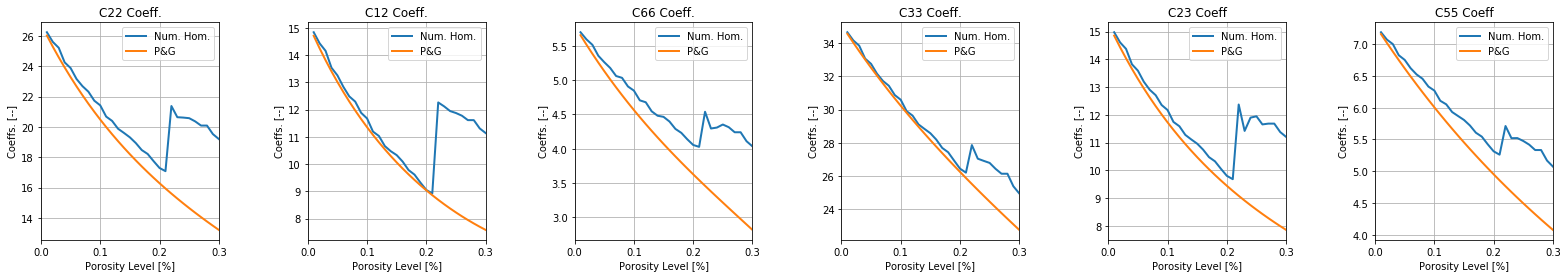

In [16]:
# Now, compute the curves obtained using 
# the numerical homogenization
fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(30,4))
fig.subplots_adjust(left=0.2,wspace=0.5)
for n in range(0,6):
    # Define coefficient to plot
    ii,jj,kk,ll = indexes[n]
    # Plot of main homogenized coeffs.
    ax[n].plot(porosities, C_hom[ii,jj,kk,ll,:], 
               linewidth=2)
    if n == 0:
        ax[n].plot(porosities, C22_m, 
                   linewidth=2)
        ax[n].set_title('C22 Coeff.')
        print("Norm infty at C22 of difference",
              np.linalg.norm(C_hom[ii,jj,kk,ll,:]-C22_m, 
                             np.inf))
        # Compute the percentage error
        C22_h = C_hom[ii,jj,kk,ll,:]
        error = lambda phi: 100*np.abs(C22_h[phi]-C22_m[phi])/C22_m[phi]
        print("Error C22 at 10%: {0:.3f}, at 20%: {1:.3f}%".format(
              error(9), error(19)))
    elif n == 1:
        ax[n].plot(porosities, C12_m, 
                   linewidth=2)
        ax[n].set_title('C12 Coeff.')
        print("Norm infty at C12 of difference",
              np.linalg.norm(C_hom[ii,jj,kk,ll,:]-C12_m, 
                             np.inf))
        # Compute the percentage error
        C12_h = C_hom[ii,jj,kk,ll,:]
        error = lambda phi: 100*np.abs(C12_h[phi]-C12_m[phi])/C12_m[phi]
        print("Error C12 at 10%: {0:.3f}, at 20%: {1:.3f}%".format(
              error(9), error(19)))
    elif n == 2:
        ax[n].plot(porosities, C66_m,
                   linewidth=2)
        ax[n].set_title('C66 Coeff.')
        print("Norm infty at C66 of difference",
              np.linalg.norm(C_hom[ii,jj,kk,ll,:]-C66_m,
                             np.inf))  
        # Compute the percentage error
        C66_h = C_hom[ii,jj,kk,ll,:]
        error = lambda phi: 100*np.abs(C66_h[phi]-C66_m[phi])/C66_m[phi]
        print("Error C66 at 10%: {0:.3f}, at 20%: {1:.3f}%".format(
              error(9), error(19)))
    elif n == 3:
        ax[n].plot(porosities, C33_m,
                   linewidth=2)
        ax[n].set_title('C33 Coeff.')
        print("Norm infty at C33 of difference",
              np.linalg.norm(C_hom[ii,jj,kk,ll,:]-C33_m,
                             np.inf))
        # Compute the percentage error
        C33_h = C_hom[ii,jj,kk,ll,:]
        error = lambda phi: 100*np.abs(C33_h[phi]-C33_m[phi])/C33_m[phi]
        print("Error C33 at 10%: {0:.3f}, at 20%: {1:.3f}%".format(
              error(9), error(19)))
    elif n == 4:
        ax[n].plot(porosities, C23_m,
                   linewidth=2)
        ax[n].set_title('C23 Coeff')
        print("Norm infty at C23 of difference",
              np.linalg.norm(C_hom[ii,jj,kk,ll,:]-C23_m,
                             np.inf))
        # Compute the percentage error
        C23_h = C_hom[ii,jj,kk,ll,:]
        error = lambda phi: 100*np.abs(C23_h[phi]-C23_m[phi])/C23_m[phi]
        print("Error C23 at 10%: {0:.3f}, at 20%: {1:.3f}%".format(
              error(9), error(19)))
    else:
        ax[n].plot(porosities, C55_m,
                   linewidth=2)
        ax[n].set_title('C55 Coeff')
        print("Norm infty at C55 of difference",
              np.linalg.norm(C_hom[ii,jj,kk,ll,:]-C55_m,
                             np.inf))
        # Compute the percentage error
        C55_h = C_hom[ii,jj,kk,ll,:]
        error = lambda phi: 100*np.abs(C55_h[phi]-C55_m[phi])/C55_m[phi]
        print("Error C55 at 10%: {0:.3f}, at 20%: {1:.3f}%".format(
              error(9), error(19)))
    # Mark the other options for the figure
    ax[n].set_xlabel('Porosity Level [%]')
    ax[n].set_ylabel('Coeffs. [--]')
    ax[n].set_xlim([0., 0.3])
    ax[n].legend(['Num. Hom.', 'P&G'], loc='best')
    ax[n].grid()

#plt.savefig("Plots/CaseDerivG_AblockModBdryMod.pdf", dpi=150, bbox_inches='tight')
plt.show()


In [12]:
# Save data in pickle format
import pickle, io
# Define data to save
data_save = {'structure': structure, 
             'MinHeigth': box_mesh.hmin(),
             'NumCells': box_mesh.num_cells(),
             'NumVerts': box_mesh.num_vertices(),
             'C22': list(C_hom[0,0,0,0,:]),
             'C66': list(C_hom[0,1,0,1,:]),
             'C33': list(C_hom[2,2,2,2,:]),
             'C23': list(C_hom[1,1,2,2,:]),
             'C55': list(C_hom[1,2,1,2,:]),
             'C12': list(C_hom[0,0,1,1,:])}
# Define output file
output = 'DataPICKLE/Inc_'+str(structure)+'3DPart'+ \
         str(part)+'Null.pickle'
with io.open(output, 'wb') as handle:
    pickle.dump(data_save, handle, 
               protocol=pickle.HIGHEST_PROTOCOL)

### Obtain plot combining the curves for the different hom. coeffs.

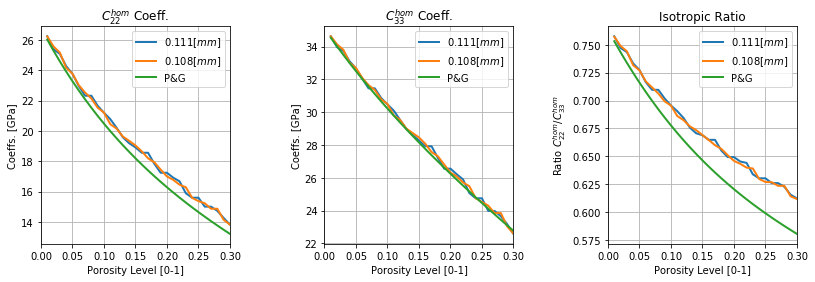

In [17]:
import pickle, io
import matplotlib.pyplot as plt
%matplotlib inline

# First, Obtain the structure
structure = 'Circular'
# Define an array of porosities
porosities = np.arange(0.01, 0.31, step=0.01)
# Now, create the plot figure
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,4))
fig.subplots_adjust(left=0.2, wspace=0.5)
# Define legend label
legend_name = []

# Iterate over the files
for part in [30, 35]:
    filename = 'DataPICKLE/Inc_'+str(structure)+ \
               '3DPart'+str(part)+'Null.pickle'
    with open(filename, 'rb') as handle:
        data_saved = pickle.load(handle)
    min_heigth = round(data_saved['MinHeigth'],3)
    legend_name.append(str(min_heigth)+\
                       '[$m m$]')
    # Now, plot the case C22
    ax[0].plot(porosities, data_saved['C22'],
               linewidth=2)
    # plot the case C33
    ax[1].plot(porosities, data_saved['C33'],
               linewidth=2)
    # Now, compute the anisotropic ratio
    ratio = np.array(data_saved['C22'])/\
            np.array(data_saved['C33'])
    ax[2].plot(porosities, ratio,
              linewidth=2)
# Append legend tag of P&G
legend_name.append('P&G')
# Add more formating for the plot.
for n in range(0,3):
    if n == 0:
        ax[n].plot(porosities, C22_m,
                  linewidth=2)
        ax[n].set_title('$C_{22}^{hom}$ Coeff.')
        
    elif n == 1:
        ax[n].plot(porosities, C33_m,
                  linewidth=2)
        ax[n].set_title('$C_{33}^{hom}$ Coeff.')
    else:
        ax[n].plot(porosities, C22_m/C33_m,
                  linewidth=2)
        ax[n].set_title('Isotropic Ratio')
        
     # set ylabel at each case
    if n <= 1:
        ax[n].set_ylabel('Coeffs. [GPa]')
    else:
        ax[n].set_ylabel('Ratio $C_{22}^{hom}/C_{33}^{hom}$')
        
    # Mark the other options for the figure
    ax[n].set_xlabel('Porosity Level [0-1]')
    ax[n].set_xlim([0.0, 0.3])
    # Add legend
    ax[n].legend(legend_name)
    ax[n].grid()
# save it!
for _ in ['.pdf', '.png']:
    filename = 'Plots/3DCellProb_MainHomCoeffs'+str(structure)+_
    plt.savefig(filename, dpi=150, bbox_inches='tight')
# show plot
plt.show()

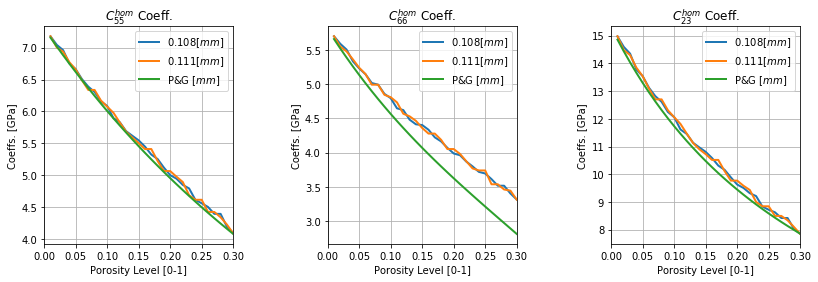

In [18]:
# First, Obtain the structure
structure = 'Circular'
# Now, create the plot figure
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,4))
fig.subplots_adjust(left=0.2, wspace=0.5)
# Define legend label
legend_name = []

# Iterate over the files
for part in [35, 30]:
    filename = 'DataPICKLE/Inc_'+str(structure)+ \
               '3DPart'+str(part)+'Null.pickle'
    with open(filename, 'rb') as handle:
        data_saved = pickle.load(handle)
    min_heigth = round(data_saved['MinHeigth'],3)
    legend_name.append(str(min_heigth)+\
                       '[$m m$]')
    # Now, plot the case C55
    ax[0].plot(porosities, data_saved['C55'],
               linewidth=2)
    # plot the case C66
    ax[1].plot(porosities, data_saved['C66'],
               linewidth=2)
    # Now, the case C23
    ax[2].plot(porosities, data_saved['C23'],
              linewidth=2)
# Append legend tag of P&G
legend_name.append('P&G [$mm$]')
# Add more formating for the plot.
for n in range(0,3):
    if n == 0:
        ax[n].plot(porosities, C55_m,
                  linewidth=2)
        ax[n].set_title('$C_{55}^{hom}$ Coeff.')
    elif n == 1:
        ax[n].plot(porosities, C66_m,
                  linewidth=2)
        ax[n].set_title('$C_{66}^{hom}$ Coeff.')
    else:
        ax[n].plot(porosities, C23_m,
                  linewidth=2)
        ax[n].set_title('$C_{23}^{hom}$ Coeff.')
    # set ylabel at each case
    ax[n].set_ylabel('Coeffs. [GPa]')
    # Mark the other options for the figure
    ax[n].set_xlabel('Porosity Level [0-1]')
    ax[n].set_xlim([0.0, 0.3])
    # Add legend
    ax[n].legend(legend_name)
    ax[n].grid()
# save it!
for _ in ['.pdf', '.png']:
    filename = 'Plots/3DCellProb_OthersHomCoeffs'+str(structure)+_
    plt.savefig(filename, dpi=150, bbox_inches='tight')
# show plot
plt.show()

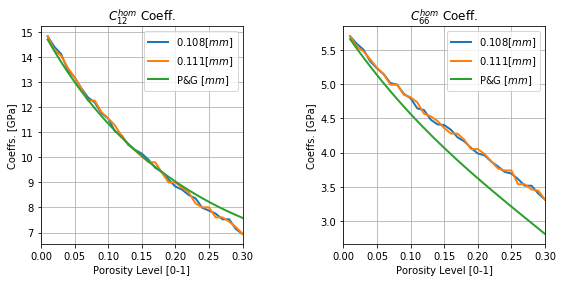

In [20]:
# First, Obtain the structure
structure = 'Circular'
# Now, create the plot figure
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
fig.subplots_adjust(left=0.2, wspace=0.5)
# Define legend label
legend_name = []

# Iterate over the files
for part in [35, 30]:
    filename = 'DataPICKLE/Inc_'+str(structure)+ \
               '3DPart'+str(part)+'Null.pickle'
    with open(filename, 'rb') as handle:
        data_saved = pickle.load(handle)
    min_heigth = round(data_saved['MinHeigth'],3)
    legend_name.append(str(min_heigth)+\
                       '[$m m$]')
    # Now, plot the case C12
    ax[0].plot(porosities, data_saved['C12'],
               linewidth=2)
    # plot the case C66
    ax[1].plot(porosities, data_saved['C66'],
               linewidth=2)
# Append legend tag of P&G
legend_name.append('P&G [$mm$]')
# Add more formating for the plot.
for n in range(0,2):
    if n == 0:
        ax[n].plot(porosities, C12_m,
                  linewidth=2)
        ax[n].set_title('$C_{12}^{hom}$ Coeff.')
    else:
        ax[n].plot(porosities, C66_m,
                  linewidth=2)
        ax[n].set_title('$C_{66}^{hom}$ Coeff.')
    # set ylabel at each case
    ax[n].set_ylabel('Coeffs. [GPa]')
    # Mark the other options for the figure
    ax[n].set_xlabel('Porosity Level [0-1]')
    ax[n].set_xlim([0.0, 0.3])
    # Add legend
    ax[n].legend(legend_name)
    ax[n].grid()
# save it!
# Recall to save in pdf format also!.
for _ in ['.pdf', '.png']:
    filename = 'Plots/Dif3DCellProb_OthersHomCoeffs'+str(structure)+_
    plt.savefig(filename, dpi=150, bbox_inches='tight')
# show plot
plt.show()

In [23]:
import scipy.io as sio
import numpy as np
# Iterate over the files
def ErrorDifference(Levels):
    """
    *Calculate percent error associated to the data*
    Levels: list of porosity levels to compute error.
    reference: reference array of values
    """
    # Obtain the experimental data from .mat file
    C_mathilde = sio.loadmat('Files_mat/C_values_mathilde.mat')
    # Define the constants
    # The stiffness constants in [GPa] --> [g/mm(\mu sec)^2]
    # are given by the mathilde .mat (transverse isotropic)
    C22_m = np.reshape(C_mathilde['C11'], (30,))#*1E-3
    C12_m = np.reshape(C_mathilde['C12'], (30,))
    C23_m = np.reshape(C_mathilde['C13'], (30,))#*1E-3
    C33_m = np.reshape(C_mathilde['C33'], (30,))#*1E-3
    C55_m = np.reshape(C_mathilde['C55'], (30,))#*1E-3
    C66_m = np.reshape(C_mathilde['C66'], (30,))
    # Obtain the density
    d = np.reshape(C_mathilde['d'], (30,))#*1E-3
    # Define Prediction Error function
    def PredError(Po, Ref_Data, Sim_Data):
        # Define function of errors for each coefficients
        ErrorLevel = 100*np.abs(Sim_Data[Po]-Ref_Data[Po])/Ref_Data[Po]
        return ErrorLevel
    # First, consider fixed datas of consideration
    for part in [35, 30, 24]:
        # Select filename
        filename = 'DataPICKLE/Inc_'+str(structure)+ \
                   '3DPart'+str(part)+'Null.pickle'
        # Open the pickle file
        with open(filename, 'rb') as handle:
            data_saved = pickle.load(handle)
        # Obtain heigth of elements
        min_heigth = round(data_saved['MinHeigth'],3)
        print("Case of heigth elemens: {}".format(min_heigth))
        # Obtain the list of values at different porosities
        C22_sim, C33_sim = data_saved['C22'], data_saved['C33']
        C55_sim, C66_sim = data_saved['C55'], data_saved['C66']
        C23_sim, C12_sim = data_saved['C23'], data_saved['C12']
        # Obtain error associated to certain porosity levels
        for level in Levels:
            index = int(level*100)-1 # Obtained index for list
            # Return errors for each coefficients
            print("Error C22 at {0}%: {1:.3f}%".format(
                  int(level*100),
                  PredError(index, C22_m, C22_sim)))
            print("Error C33 at {0}%: {1:.3f}%".format(
                  int(level*100),
                  PredError(index, C33_m, C33_sim)))
            print("Error C55 at {0}%: {1:.3f}%".format(
                  int(level*100),
                  PredError(index, C55_m, C55_sim)))
            print("Error C66 at {0}%: {1:.3f}%".format(
                  int(level*100),
                  PredError(index, C66_m, C66_sim)))
            print("Error C12 at {0}%: {1:.3f}%".format(
                  int(level*100),
                  PredError(index, C12_m, C12_sim)))
            print("Error C23 at {0}%: {1:.3f}%".format(
                  int(level*100),
                  PredError(index, C23_m, C23_sim)))
            print("\n")
    # Return nothing!
    return 

In [24]:
ErrorDifference([0.05, 0.10, 0.15, 0.20])

Case of heigth elemens: 0.108
Error C22 at 5%: 2.138%
Error C33 at 5%: 0.596%
Error C55 at 5%: 0.671%
Error C66 at 5%: 1.873%
Error C12 at 5%: 1.440%
Error C23 at 5%: 1.813%


Error C22 at 10%: 3.573%
Error C33 at 10%: 0.924%
Error C55 at 10%: 1.309%
Error C66 at 10%: 5.024%
Error C12 at 10%: 1.757%
Error C23 at 10%: 2.796%


Error C22 at 15%: 4.642%
Error C33 at 15%: 1.085%
Error C55 at 15%: 1.677%
Error C66 at 15%: 8.173%
Error C12 at 15%: 0.926%
Error C23 at 15%: 3.158%


Error C22 at 20%: 4.370%
Error C33 at 20%: 0.269%
Error C55 at 20%: 0.954%
Error C66 at 20%: 9.977%
Error C12 at 20%: 2.192%
Error C23 at 20%: 1.930%


Case of heigth elemens: 0.111
Error C22 at 5%: 2.107%
Error C33 at 5%: 0.518%
Error C55 at 5%: 0.594%
Error C66 at 5%: 2.045%
Error C12 at 5%: 1.462%
Error C23 at 5%: 1.802%


Error C22 at 10%: 3.503%
Error C33 at 10%: 0.845%
Error C55 at 10%: 1.134%
Error C66 at 10%: 5.339%
Error C12 at 10%: 1.819%
Error C23 at 10%: 2.775%


Error C22 at 15%: 3.936%
Error C33 at 15